# SI 670 Final Project: Predicting Value of Jeopardy Questions

### Data Exploration & Preparation

In [1]:
# read in and preview data

import pandas as pd

jeopardy_data = pd.read_csv('JEOPARDY_CSV.csv')
# remove spaces from column names
jeopardy_data.columns = [col.strip() for col in jeopardy_data.columns]
print(jeopardy_data.shape)
jeopardy_data.head()

(216930, 7)


,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [2]:
# extract subset of the data using the following criteria:
# (1) only 'Jeopardy!' round
# (2) no answers with numbers or questions containing images/links
# (3) only shows after 4000 (to limit amount of data)
# (4) only questions with 5 or more words
# (5) only questions with a value of $200 or $1000

jeopardy_data_sub = jeopardy_data[jeopardy_data['Round'] == 'Jeopardy!']
jeopardy_data_sub = jeopardy_data_sub[jeopardy_data_sub.Answer.str.isalpha() == True]
jeopardy_data_sub = jeopardy_data_sub[~jeopardy_data_sub.Question.str.contains("<a href=")]
jeopardy_data_sub = jeopardy_data_sub[jeopardy_data_sub['Show Number'] >= 4000]
jeopardy_data_sub = jeopardy_data_sub[jeopardy_data_sub['Question'].str.split().str.len() >= 5]

import random
# get a sample of 1,000 for each Value
jeopardy_data_sub_200 = jeopardy_data_sub[jeopardy_data_sub['Value']=='$200'].sample(2000, random_state=670)
jeopardy_data_sub_1000 = jeopardy_data_sub[jeopardy_data_sub['Value']=='$1000'].sample(2000, random_state=670)
jeopardy_data_sub = pd.concat([jeopardy_data_sub_200, jeopardy_data_sub_1000])


print(jeopardy_data_sub.shape)
jeopardy_data_sub.head(10)

(4000, 7)


,Show Number,Air Date,Round,Category,Value,Question,Answer
166403,4536,2004-05-03,Jeopardy!,"DOUBLE A, B, Cs",$200,"I'm this, you're glue, everything you say boun...",rubber
781,4335,2003-06-06,Jeopardy!,MY PLACE?,$200,"A Norman could say, ""I'm the king of the motte...",castle
119920,5224,2007-05-03,Jeopardy!,POTPOURRI,$200,Shelley & Eliot would be happy to know that Ap...,poetry
33882,5668,2009-04-08,Jeopardy!,IT'S A COUNTRY THING,$200,Hat dance & jumping bean,Mexican
186569,6247,2011-11-15,Jeopardy!,MELTING POTPOURRI,$200,"""Our actors"", says Prospero, ""were all spirits...",air
45283,5687,2009-05-05,Jeopardy!,ARCHAEOLOGY,$200,In 1996 Franck Goddio discovered her palace un...,Cleopatra
184063,5023,2006-06-14,Jeopardy!,& TAKIN' NAMES,$200,"World poverty fighter, Time magazine Person of...",Bono
85474,5139,2007-01-04,Jeopardy!,BEAN,$200,This bean that shares the name of a South Amer...,lima
155694,5853,2010-02-10,Jeopardy!,BE TRUE TO YOUR SCHOOL,$200,"The benefactor for whom this West Lafayette, I...",Purdue
147690,4293,2003-04-09,Jeopardy!,DECODE THE PERSONAL AD,$200,"To start with, S. is for this",single


### Feature Extraction

In [3]:
# use word embeddings to find the similarity between the question/topic and the answer

import gensim 

# source: https://github.com/eyaler/word2vec-slim
# example of pre-trained word embeddings, trained on Google News documents
model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300-SLIM.bin", binary=True)

# source: https://stackoverflow.com/questions/22129943/how-to-calculate-the-sentence-similarity-using-word2vec-model-of-gensim-with-pyt

import numpy as np
from scipy import spatial

index2word_set = set(model.wv.index2word)

def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

# function to calculate the similarity between two sentences
def calculate_sim(text1, text2):
    s1_afv = avg_feature_vector(text1, model=model, num_features=300, index2word_set=index2word_set)
    s2_afv = avg_feature_vector(text2, model=model, num_features=300, index2word_set=index2word_set)
    sim = 1 - spatial.distance.cosine(s1_afv, s2_afv)
    return sim

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [4]:
# function to count the average word length in the sentence 
import numpy as np

def avg_word_length(text):
    lens = []
    for word in text.split():
        lens.append(len(word))
    return np.mean(lens)

# function to count the max word length in the sentence 
def longest_word(text):
    lens = []
    for word in text.split():
        lens.append(len(word))
    try:
        return np.max(lens)
    except:
        return 0

In [5]:
import textstat as ts # source: https://pypi.org/project/textstat/

# how many words are in the question?
jeopardy_data_sub['Question Len'] = jeopardy_data_sub['Question'].apply(lambda x: ts.lexicon_count(x, removepunct=True))
# what is the readability of the question?
jeopardy_data_sub['Flesch Reading Ease Score'] = jeopardy_data_sub['Question'].apply(lambda text: ts.flesch_reading_ease(text))
# what is the grade level associated the question?
jeopardy_data_sub['Flesch-Kincaid Grade Level'] = jeopardy_data_sub['Question'].apply(lambda text:ts.flesch_kincaid_grade(text))
# longest word in question? 
jeopardy_data_sub['Longest Word (Question)'] = jeopardy_data_sub['Question'].apply(lambda text:longest_word(text))
# longest word in answer?
jeopardy_data_sub['Longest Word (Answer)'] = jeopardy_data_sub['Answer'].apply(lambda text:longest_word(text))


# clean questions/answers by lowercasing and removing stop words

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

jeopardy_data_sub['Question_cleaned'] = jeopardy_data_sub['Question'].apply(lambda x: " ".join([word.lower() for word in x.split() if word.lower() not in stopwords]))
jeopardy_data_sub['Answer_cleaned'] = jeopardy_data_sub['Answer'].apply(lambda x: " ".join([word.lower() for word in x.split() if word.lower() not in stopwords]))
jeopardy_data_sub['Category_cleaned'] = jeopardy_data_sub['Category'].apply(lambda x: " ".join([word.lower() for word in x.split() if word.lower() not in stopwords]))

# what is the average length of a word in the answer?
jeopardy_data_sub['Average Answer Word Length (Cleaned)'] = jeopardy_data_sub['Answer_cleaned'].apply(lambda text: avg_word_length(text))
# how many words are in the answer?
jeopardy_data_sub['Answer Len (Cleaned)'] = jeopardy_data_sub['Answer_cleaned'].apply(lambda x: ts.lexicon_count(x, removepunct=True))

# similarity between the question and answer
jeopardy_data_sub['QA Similarity'] = jeopardy_data_sub.apply(lambda x: calculate_sim(x.Question_cleaned, x.Answer_cleaned), axis=1)
# similarity between the topic and answer
jeopardy_data_sub['TA Similarity'] = jeopardy_data_sub.apply(lambda x: calculate_sim(x.Category_cleaned, x.Answer_cleaned), axis=1)

jeopardy_data_sub.groupby('Value')[['Flesch Reading Ease Score', 
         'Flesch-Kincaid Grade Level', 'Longest Word (Question)', 'Longest Word (Answer)',
         'Average Answer Word Length (Cleaned)', 'Answer Len (Cleaned)', 'QA Similarity', 'TA Similarity']].mean()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


,Flesch Reading Ease Score,Flesch-Kincaid Grade Level,Longest Word (Question),Longest Word (Answer),Average Answer Word Length (Cleaned),Answer Len (Cleaned),QA Similarity,TA Similarity
Value,,,,,,,,
$1000,70.390675,6.98215,9.8085,7.0475,7.060150,0.9975,0.275571,0.165164
$200,72.825295,6.51860,9.5480,6.5100,6.533434,0.9945,0.275524,0.168144


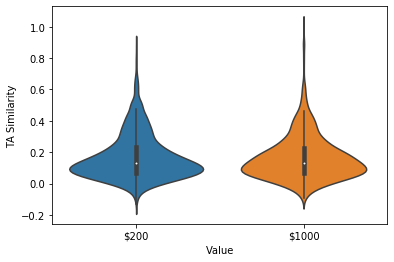

In [6]:
import seaborn as sns 
sns.violinplot(x="Value", y="TA Similarity", data=jeopardy_data_sub)

### Model Building & Evaluation

In [7]:
# split data into training and test sets

from sklearn.model_selection import train_test_split

cols_sub = ['Flesch Reading Ease Score', 
         'Flesch-Kincaid Grade Level', 'Longest Word (Question)', 'Longest Word (Answer)',
         'Average Answer Word Length (Cleaned)', 'QA Similarity', 'TA Similarity']

X = jeopardy_data_sub[cols_sub]
y = jeopardy_data_sub['Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
# checks
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3000, 7)
(3000,)
(1000, 7)
(1000,)


In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

scaler = ColumnTransformer(        
        remainder='passthrough', 
        transformers=[
            ('scaler', MinMaxScaler() , ['Flesch Reading Ease Score', 
         'Flesch-Kincaid Grade Level', 'Longest Word (Question)', 'Longest Word (Answer)',
         'Average Answer Word Length (Cleaned)'])])

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train_scaled)
X_test_imp = imputer.transform(X_test_scaled)

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

gnb = GaussianNB()
gnb.fit(X_train_imp, y_train)
preds = gnb.predict(X_test_imp)
print("Training Score:", gnb.score(X_train_imp, y_train))
print("Testing Score:", gnb.score(X_test_imp, y_test))
print(classification_report(y_test, preds))

Training Score: 0.5656666666666667
Testing Score: 0.55
              precision    recall  f1-score   support

       $1000       0.56      0.47      0.51       500
        $200       0.54      0.63      0.58       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000



In [10]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(X_train_imp, y_train)
preds = svc.predict(X_test_imp)
print("Training Score:", svc.score(X_train_imp, y_train))
print("Testing Score:", svc.score(X_test_imp, y_test))
print(classification_report(y_test, preds))

Training Score: 0.571
Testing Score: 0.564
              precision    recall  f1-score   support

       $1000       0.57      0.55      0.56       500
        $200       0.56      0.58      0.57       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.56      0.56      0.56      1000



In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

param_grid = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
}

mlp = MLPClassifier(alpha=0.00001, random_state=0)
grid_search = GridSearchCV(estimator = mlp, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train_imp, y_train)
grid_search.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   11.5s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'alpha': 1e-05}

In [12]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=1e-05, random_state=0)
mlp.fit(X_train_imp, y_train)
preds = mlp.predict(X_test_imp)
print("Training Score:", mlp.score(X_train_imp, y_train))
print("Testing Score:", mlp.score(X_test_imp, y_test))
print(classification_report(y_test, preds))

Training Score: 0.5806666666666667
Testing Score: 0.57
              precision    recall  f1-score   support

       $1000       0.58      0.52      0.55       500
        $200       0.56      0.62      0.59       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': [1,2,3,4,5],
    'max_features': [2, 3, 4],
    'n_estimators': [100, 200, 500]
}

rf = RandomForestClassifier(random_state=670)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train_imp, y_train)
grid_search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   41.6s finished


{'max_depth': 2, 'max_features': 2, 'n_estimators': 100}

In [14]:
rf = RandomForestClassifier(max_depth=2, max_features=2, n_estimators=100, random_state=670)
rf.fit(X_train_imp, y_train)
preds = rf.predict(X_test_imp)
print("Training Score:", rf.score(X_train_imp, y_train))
print("Testing Score:", rf.score(X_test_imp, y_test))

print(classification_report(y_test, preds))

Training Score: 0.5856666666666667
Testing Score: 0.58
              precision    recall  f1-score   support

       $1000       0.59      0.55      0.57       500
        $200       0.58      0.61      0.59       500

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.58      1000
weighted avg       0.58      0.58      0.58      1000



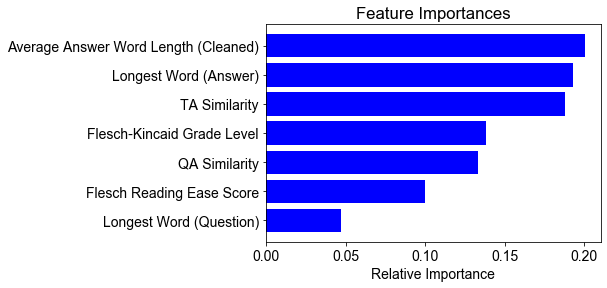

In [15]:
# visualize feature importances from RF model
# source: https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
import matplotlib.pyplot as plt
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

font = {'family' : 'arial',
        'size'   :14}

plt.rc('font', **font)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()